<p align = "center" draggable=”false” ><img src="https://github.com/AI-Maker-Space/LLM-Dev-101/assets/37101144/d1343317-fa2f-41e1-8af1-1dbb18399719"
     width="200px"
     height="auto"/>
</p>

<h1 align="center" id="heading">AI Makerspace: Pydantic AI Event</h1>

In this event, we'll be building a joke generator using the Pydantic AI framework!

The Pydantic AI framework is a new way to build agents based on Pydantics previous works on data validation and data models.

We'll start with our dependencies:

In [ ]:
!pip install -qU pydantic-ai logfire devtools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.5/128.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We're going to need a few API keys for this example:

We're going to leverage the new "best vibe" agent for determining if the jokes are hilarious - and Claude 3.7 Sonnet for generating some initial jokes.

In [ ]:
import os
import getpass

os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')
os.environ['LOGFIRE_API_KEY'] = getpass.getpass('LOGFIRE API Key:')
os.environ["ANTHROPIC_API_KEY"] = getpass.getpass('Anthropic API Key:')

OpenAI API Key:··········
LOGFIRE API Key:··········
Anthropic API Key:··········


Becuase we're in the notebook, we'll need to nest asyncio to run our code.

In [ ]:
import nest_asyncio
nest_asyncio.apply()

BIG WALL OF IMPORT STATEMENTS!

In [ ]:
from __future__ import annotations as _annotations

from dataclasses import dataclass, field
from pathlib import Path
from typing import Annotated

import logfire
from devtools import debug
from pydantic_graph import BaseNode, Edge, End, Graph, GraphRunContext, HistoryStep

from pydantic_ai import Agent
from pydantic_ai.format_as_xml import format_as_xml
from pydantic_ai.messages import ModelMessage

We'll be using Logfire to track our events!

You can sign up for a free account at https://pydantic.dev/logfire!

In [ ]:
logfire.configure(token=os.environ["LOGFIRE_API_KEY"])

## Building our Agents!

In order to build a multi-agent joke generator, we'll need to build a couple of agents.

We'll start with our "Joke Generator" agent.

> NOTE: The "instrument=True" is important here. This will allow us to track the events in Logfire.

In [ ]:
joke_generator_agent = Agent(
    "anthropic:claude-3-7-sonnet-latest",
    result_type=str,
    instrument=True
)

Then, similar to other agent frameworks, we'll want to define our state.

> NOTE: We'll limit ourselves to 5 attempts to generate a joke, just in case Claude is having an off day.

In [ ]:
@dataclass
class JokeState:
    joke: str | None = None
    joke_generator_agent_messages: list[ModelMessage] = field(default_factory=list)
    evaluate_agent_messages: list[ModelMessage] = field(default_factory=list)
    attempts: int = 0
    max_attempts: int = 5

Next, we'll set up of our "Joke Generator" agent, which will be responsible both for generating jokes, and for incorporating feedback into the joke generation process.

Our JokeGenerator will take our BaseNode with our JokeState, and will return an Evaluate node.

This is the way we can produce our graph! We can effectively chain together our nodes to produce a graph - including, as we'll see, conditional logic - just like in LangGraph!

In [ ]:
@dataclass
class JokeGenerator(BaseNode[JokeState]):
    feedback: str | None = None

    async def run(self, ctx: GraphRunContext[JokeState]) -> Evaluate:
        ctx.state.attempts += 1

        prompt = 'Make up a joke about cats. It should be both dope, and funny.'

        if self.feedback:
            prompt = f"""Make up a joke about cats. It should be both dope, and funny.

Previous attempt: {ctx.state.joke}

Feedback on previous attempt: {self.feedback}

Please create a new joke that addresses this feedback."""

        result = await joke_generator_agent.run(
            prompt,
            message_history=ctx.state.joke_generator_agent_messages,
        )
        ctx.state.joke_generator_agent_messages += result.all_messages()
        ctx.state.joke = result.data

        return Evaluate()

Next, we can produce another node which will be responsible for kicking off our evaluation process.

In [ ]:
@dataclass
class ProducedJoke(BaseNode[JokeState]):
    joke: str | None = None

    async def run(self, ctx: GraphRunContext[JokeState]) -> Evaluate:
        assert self.joke is not None
        return Evaluate(self.joke)

We'll need to create some Evaluation state, which will help the LLM determine how to respond.

In [ ]:
@dataclass
class EvaluationResult:
    dope: bool
    funny: bool
    comment: str

Our evaluation agent will be a GPT-4.5 preview model, which will be responsible for evaluating the joke. We're using this model because, while it's not great at reasoning, it's great at being funny!

In [ ]:
evaluate_agent = Agent(
    'openai:gpt-4.5-preview',
    result_type=EvaluationResult,
    system_prompt='Given a joke, evaluate if the joke is dope, or nope - also evaluate if the joke is funny. It needs to be *really* good. Suggest improvements on the joke if it is not.',
)

Now we'll create our Evaluate node.

Notice how we're returning a Congratulate or Reprimand node, depending on the evaluation - this is how we add complexity to our graph.

In [ ]:
@dataclass
class Evaluate(BaseNode[JokeState]):
    async def run(
        self,
        ctx: GraphRunContext[JokeState],
    ) -> Congratulate | Reprimand | End:
        assert ctx.state.joke is not None

        result = await evaluate_agent.run(
            format_as_xml({'joke': ctx.state.joke}),
            message_history=ctx.state.evaluate_agent_messages,
        )
        ctx.state.evaluate_agent_messages += result.all_messages()

        if ctx.state.attempts >= ctx.state.max_attempts:
            print(f"Reached maximum attempts ({ctx.state.max_attempts}). Best joke so far: {ctx.state.joke}")
            print(f"Final feedback: {result.data.comment}")
            return End(None)

        if result.data.funny and result.data.dope:
            return Congratulate(result.data.comment)
        else:
            return Reprimand(result.data.comment)

Next, we'll create our Congratulate and Reprimand nodes.

These are our "success" and "failure" states - they'll be used to determine the next node in our graph.

`End` if the joke is good.

In [ ]:
@dataclass
class Congratulate(BaseNode[JokeState, None, None]):
    comment: str

    async def run(
        self, ctx: GraphRunContext[JokeState]
    ) -> Annotated[End, Edge(label='success')]:
        print(f'Found a funny and dope joke after {ctx.state.attempts} attempts!')
        print(f'Joke: {ctx.state.joke}')
        print(f'Feedback: {self.comment}')
        return End(None)

`Reprimand` if the joke needs improvement.

In [ ]:
@dataclass
class Reprimand(BaseNode[JokeState]):
    comment: str

    async def run(self, ctx: GraphRunContext[JokeState]) -> JokeGenerator:
        print(f'Attempt {ctx.state.attempts}: {ctx.state.joke}')
        print(f'Feedback: {self.comment}')
        return JokeGenerator(feedback=self.comment)

Finally, we'll create our graph!

Notice that we can just plop the nodes in, as we define their connections in each node.

In [ ]:
question_graph = Graph(
    nodes=(JokeGenerator, Evaluate, Congratulate, Reprimand), state_type=JokeState
)

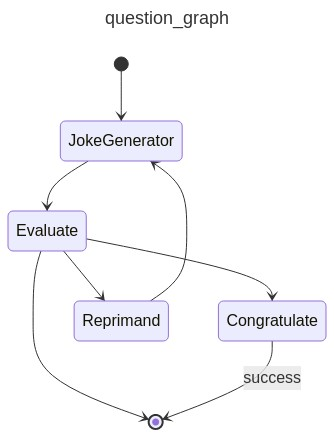

In [ ]:
from IPython.display import Image, display

display(Image(question_graph.mermaid_image(start_node=JokeGenerator)))

Finally, we can run our graph - it's as easy as running the next node in a while loop until we hit our `End` node!

In [ ]:
async def run_automated_joke_generator():
    state = JokeState()
    node = JokeGenerator()
    history: list[HistoryStep[JokeState, None]] = []
    with logfire.span('run automated joke generator'):
        while True:
            node = await question_graph.next(node, history, state=state)
            if isinstance(node, End):
                debug([e.data_snapshot() for e in history])
                break

result = await run_automated_joke_generator()

17:01:41.549 run automated joke generator
17:01:41.550   run node JokeGenerator
17:01:41.551     joke_generator_agent run
17:01:41.552       preparing model request params
17:01:41.552       chat claude-3-7-sonnet-latest
17:01:42.746   run node Evaluate
17:01:46.711   run node Reprimand
Attempt 1: Why did the cat become a famous DJ?

Because they had the purrfect beats and always knew how to drop the meow-mix!
Feedback: The joke is cute but lacks a punchy impact. Consider enhancing the punchline for a stronger comedic effect, perhaps by incorporating a playful twist related to DJ culture or music.
17:01:46.712   run node JokeGenerator
17:01:46.713     joke_generator_agent run
17:01:46.714       preparing model request params
17:01:46.714       chat claude-3-7-sonnet-latest
17:01:48.090   run node Evaluate
17:01:50.024   run node Congratulate
Found a funny and dope joke after 2 attempts!
Joke: What's a cat's favorite electronic music genre?

Purr-step... they love those deep bass drops 